# Plots and analysis for Monte Carlo ensembles

Corresponds to the main text results, including:
* SSP1-RCP2.6
* SSP2-RCP4.5
* SSP4-RCP6.0
* SSP5-RCP8.5

In [71]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import re, os
import matplotlib.pyplot as plt
%matplotlib inline

Colorblind-friendly palette

In [72]:
plt.style.use('tableau-colorblind10')

Set `projdir` on your system, then everything else is defined relative to that. `pwd` will just give the directory that this Jupyter notebook is housed in.

In [73]:
projdir = os.getcwd()
datdir = projdir + "/../ciam-code/output/MonteCarlo"
plotdir = projdir + "/../ciam-code/figures"

If the plot directory `plotdir` doesn't exist, make it.

In [74]:
if not os.path.exists(plotdir):
    os.makedirs(plotdir)
print("Will save plots to ",plotdir)

Will save plots to  /Users/aewsma/codes/CIAM_uncertainty_propagation/work_uncertainty_propagation/../ciam-code/figures


In [98]:
scenarios = [(1,26),(2,45),(4,60),(5,85)]
surge_option = 0
panels = ["a.","b.","c.","d.","e.","f.","g.","h."]

### Initialize some dicts of DataFrames 

Different dict eleemnts correspond to different SSP/RCP scenarios

In [99]:
df05 = {scen : None for scen in scenarios}
df50 = {scen : None for scen in scenarios}
df95 = {scen : None for scen in scenarios}
df05r = {scen : None for scen in scenarios}
df50r = {scen : None for scen in scenarios}
df95r = {scen : None for scen in scenarios}
dfS = {scen : None for scen in scenarios}
dfC = {scen : None for scen in scenarios}
dfSC = {scen : None for scen in scenarios}

## Read Monte Carlo simulation results

In [100]:
def subtract_ref_npv(dfO,dfG):
    nens = dfO.ens.max()
    npv_ref = np.zeros(nens)
    df1 = dfO.loc[dfO.time==1]
    for i in range(1,nens+1):
        # first 10 of the first timestep for a single ensemble member are OptimalCost
        # *10 to account for 10-year timestep vs annual costs
        npv_ref[i-1] = np.sum(np.array(df1.loc[df1.ens==i,"cost"])[:10])*10
    dfG.npv = dfG.npv - npv_ref
    return dfG

### 5th, 50th and 95th percentiles only (single simulations)

If you generate new simulations, you will need to replace these directory paths and/or file names.

Global NPV:

In [101]:
for (ssp,rcp) in scenarios:
    scendir = datdir + "/SSP"+str(ssp)+"_BRICK"+str(rcp)+"/"
    df05[(ssp,rcp)] = pd.read_csv(scendir+"SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p5/CIAM MC1/PostProcessing/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p5.csv")
    # to subtract off the 2010 reference period
    dfO = pd.read_csv(scendir+"SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p5/CIAM MC1/PostProcessing/globalts_"+str(rcp)+"_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p5.csv")
    df05[(ssp,rcp)] = subtract_ref_npv(dfO,df05[(ssp,rcp)])
    
    df50[(ssp,rcp)] = pd.read_csv(scendir+"SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p50/CIAM MC1/PostProcessing/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p50.csv")
    dfO = pd.read_csv(scendir+"SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p50/CIAM MC1/PostProcessing/globalts_"+str(rcp)+"_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p50.csv")
    df50[(ssp,rcp)] = subtract_ref_npv(dfO,df50[(ssp,rcp)])
    
    df95[(ssp,rcp)] = pd.read_csv(scendir+"SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p95/CIAM MC1/PostProcessing/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p95.csv")
    dfO = pd.read_csv(scendir+"SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p95/CIAM MC1/PostProcessing/globalts_"+str(rcp)+"_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p95.csv")
    df95[(ssp,rcp)] = subtract_ref_npv(dfO,df95[(ssp,rcp)])
    

Regional breakdown:

In [102]:
for (ssp,rcp) in scenarios:
    scendir = datdir + "/SSP"+str(ssp)+"_BRICK"+str(rcp)+"/"
    df05r[(ssp,rcp)] = pd.read_csv(scendir+"SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p5/CIAM MC1/PostProcessing/regionnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p5.csv")
    dfO = pd.read_csv(scendir+"SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p5/CIAM MC1/PostProcessing/regionts_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p5.csv")
    df05r[(ssp,rcp)] = df05r[(ssp,rcp)] - dfO

    df50r[(ssp,rcp)] = pd.read_csv(scendir+"SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p50/CIAM MC1/PostProcessing/regionnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p50.csv")
    dfO = pd.read_csv(scendir+"SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p50/CIAM MC1/PostProcessing/regionts_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p50.csv")
    df50r[(ssp,rcp)] = df50r[(ssp,rcp)] - dfO

    df95r[(ssp,rcp)] = pd.read_csv(scendir+"SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p95/CIAM MC1/PostProcessing/regionnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p95.csv")
    dfO = pd.read_csv(scendir+"SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p95/CIAM MC1/PostProcessing/regionts_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_p95.csv")
    df95r[(ssp,rcp)] = df95r[(ssp,rcp)] - dfO

regions = list(df05r[(1,26)].columns)


### Combine:

In [103]:
for (ssp,rcp) in scenarios:
    df05[(ssp,rcp)] = df05[(ssp,rcp)].join(df05r[(ssp,rcp)])
    df50[(ssp,rcp)] = df50[(ssp,rcp)].join(df50r[(ssp,rcp)])
    df95[(ssp,rcp)] = df95[(ssp,rcp)].join(df95r[(ssp,rcp)])

### SLR uncertainty only

In [104]:
for (ssp,rcp) in scenarios:
    slrdir = datdir + "/SSP"+str(ssp)+"_BRICK"+str(rcp)+"/SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR/CIAM MC1000/PostProcessing"
    dfS[(ssp,rcp)] = pd.read_csv(slrdir+"/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR.csv")
    dfO = pd.read_csv(slrdir+"/globalts_"+str(rcp)+"_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR.csv")
    dfS[(ssp,rcp)] = subtract_ref_npv(dfO,dfS[(ssp,rcp)])

    dfR = pd.read_csv(slrdir+"/regionnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR.csv")
    dfO = pd.read_csv(slrdir+"/regionts_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR.csv")
    dfR = dfR - dfO

    dfS[(ssp,rcp)] = dfS[(ssp,rcp)].join(dfR)
    

### CIAM socioeconomic parameter uncertainty only

In [105]:
for (ssp,rcp) in scenarios:
    ciamdir = datdir + "/SSP"+str(ssp)+"_BRICK"+str(rcp)+"/SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varyCIAM/CIAM MC1000/PostProcessing"
    dfC[(ssp,rcp)] = pd.read_csv(ciamdir+"/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varyCIAM.csv")
    dfO = pd.read_csv(ciamdir+"/globalts_"+str(rcp)+"_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varyCIAM.csv")
    dfC[(ssp,rcp)] = subtract_ref_npv(dfO,dfC[(ssp,rcp)])
    
    dfR = pd.read_csv(ciamdir+"/regionnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varyCIAM.csv")
    dfO = pd.read_csv(ciamdir+"/regionts_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varyCIAM.csv")
    dfR = dfR - dfO
    
    dfC[(ssp,rcp)] = dfC[(ssp,rcp)].join(dfR)


### Both SLR and CIAM uncertainty

In [106]:
for (ssp,rcp) in scenarios:
    bothdir = datdir + "/SSP"+str(ssp)+"_BRICK"+str(rcp)+"/SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM/CIAM MC1000/PostProcessing"
    dfSC[(ssp,rcp)] = pd.read_csv(bothdir+"/globalnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM.csv")
    dfO = pd.read_csv(bothdir+"/globalts_"+str(rcp)+"_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM.csv")
    dfSC[(ssp,rcp)] = subtract_ref_npv(dfO,dfSC[(ssp,rcp)])

    dfR = pd.read_csv(bothdir+"/regionnpv_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM.csv")
    dfO = pd.read_csv(bothdir+"/regionts_SSP"+str(ssp)+"_BRICK"+str(rcp)+"_surge"+str(surge_option)+"_varySLR_varyCIAM.csv")
    dfR = dfR - dfO
    
    dfSC[(ssp,rcp)] = dfSC[(ssp,rcp)].join(dfR)
    

### Histogram

KDE version

In [134]:
x = np.linspace(0,12000,500)
kde = {scen : {} for scen in scenarios}
kde_plot = {scen : {} for scen in scenarios}
for scen in scenarios:
    kde[scen]["S"] = stats.gaussian_kde(dfS[scen].npv)
    kde[scen]["C"] = stats.gaussian_kde(dfC[scen].npv)
    kde[scen]["SC"] = stats.gaussian_kde(dfSC[scen].npv)
    for k in kde[scen].keys():
        kde_plot[scen][k] = kde[scen][k](x)

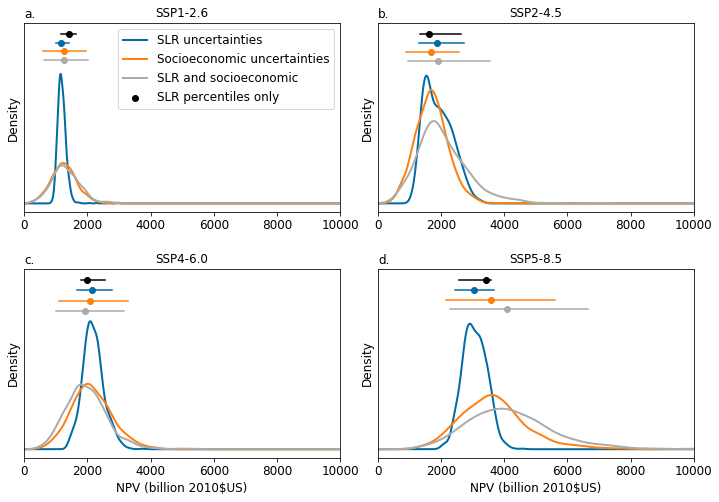

In [147]:
y00 = [0.0042,  0.0012,  0.00165, 0.0013]
dy0 = [0.00021,0.000062,0.0001,0.000075]
titles = ["SSP1-2.6", "SSP2-4.5", "SSP4-6.0", "SSP5-8.5"]
fig, ax = plt.subplots(2,2,figsize=(12,8))
for s in range(4):
    scen = scenarios[s]
    ax[int(s/2)][s%2].plot(x,kde_plot[scen]["S"], linewidth=2, color="C0", label="SLR uncertainties")
    ax[int(s/2)][s%2].plot(x,kde_plot[scen]["C"], linewidth=2, color="C1", label="Socioeconomic uncertainties")
    ax[int(s/2)][s%2].plot(x,kde_plot[scen]["SC"], linewidth=2, color="C2", label="SLR and socioeconomic")
    y0 = y00[s]; dy = dy0[s]
    ax[int(s/2)][s%2].plot([df05[scen].npv, df95[scen].npv], [y0, y0], color="black"); ax[int(s/2)][s%2].scatter(df50[scen].npv, y0, color="black", label="SLR percentiles only")
    y0 -= dy
    ax[int(s/2)][s%2].plot([dfS[scen].npv.quantile(0.05), dfS[scen].npv.quantile(0.95)], [y0, y0], color="C0"); ax[int(s/2)][s%2].scatter(dfS[scen].npv.median(), y0, color="C0")
    y0 -= dy
    ax[int(s/2)][s%2].plot([dfC[scen].npv.quantile(0.05), dfC[scen].npv.quantile(0.95)], [y0, y0], color="C1"); ax[int(s/2)][s%2].scatter(dfC[scen].npv.median(), y0, color="C1")
    y0 -= dy
    ax[int(s/2)][s%2].plot([dfSC[scen].npv.quantile(0.05), dfSC[scen].npv.quantile(0.95)], [y0, y0], color="C2"); ax[int(s/2)][s%2].scatter(dfSC[scen].npv.median(), y0, color="C2")
    if s==2 or s==3:
        ax[int(s/2)][s%2].set_xlabel("NPV (billion 2010$US)", fontsize=12); 
    ax[int(s/2)][s%2].set_ylabel("Density", fontsize=12); ax[int(s/2)][s%2].set_yticks([])
    ax[int(s/2)][s%2].set_xlim([0,10000]); ax[int(s/2)][s%2].set_xticklabels(list(range(0,12000,2000)),fontsize=12)
    if s==0:
        ax[int(s/2)][s%2].legend(fontsize=12, frameon=True)
    ax[int(s/2)][s%2].text(0,y00[s]*1.1,panels[s],fontsize=12)
    ax[int(s/2)][s%2].set_title(titles[s], fontsize=12)
plt.subplots_adjust(hspace=0.3, wspace=0.12)
fig.savefig(plotdir+"/global_damages_ssprcp.pdf", bbox_inches='tight');

In [109]:
print("5th, 50th, 95th, and 95-5th percentiles")
for scen in scenarios:
    print(scen)
    print("Percentiles only:      ",np.transpose(np.round([df05[scen].npv, df50[scen].npv, df95[scen].npv, df95[scen].npv-df05[scen].npv], 2))[0])
    print("SLR-only ensemble:     ",np.round([dfS[scen].npv.quantile(.05), dfS[scen].npv.quantile(.5), dfS[scen].npv.quantile(.95), dfS[scen].npv.quantile(.95)-dfS[scen].npv.quantile(.05)], 2))
    print("CIAM-only ensemble:    ",np.round([dfC[scen].npv.quantile(.05), dfC[scen].npv.quantile(.5), dfC[scen].npv.quantile(.95), dfC[scen].npv.quantile(.95)-dfC[scen].npv.quantile(.05)], 2))
    print("SLR and CIAM ensemble: ",np.round([dfSC[scen].npv.quantile(.05), dfSC[scen].npv.quantile(.5), dfSC[scen].npv.quantile(.95), dfSC[scen].npv.quantile(.95)-dfSC[scen].npv.quantile(.05)], 2))
    

5th, 50th, 95th, and 95-5th percentiles
(1, 26)
Percentiles only:       [1157.66 1429.42 1645.97  488.31]
SLR-only ensemble:      [1007.28 1178.26 1419.95  412.66]
CIAM-only ensemble:     [ 609.28 1244.58 1945.72 1336.45]
SLR and CIAM ensemble:  [ 619.92 1273.83 2017.43 1397.51]
(2, 45)
Percentiles only:       [1336.15 1603.58 2644.73 1308.58]
SLR-only ensemble:      [1312.46 1860.21 2709.55 1397.08]
CIAM-only ensemble:     [ 890.88 1682.18 2578.71 1687.83]
SLR and CIAM ensemble:  [ 942.53 1916.54 3550.8  2608.28]
(4, 60)
Percentiles only:       [1792.9  1997.59 2542.93  750.02]
SLR-only ensemble:      [1665.72 2150.16 2773.54 1107.83]
CIAM-only ensemble:     [1113.71 2085.81 3278.51 2164.81]
SLR and CIAM ensemble:  [1010.83 1928.23 3153.76 2142.93]
(5, 85)
Percentiles only:       [2556.51 3412.09 3589.52 1033.02]
SLR-only ensemble:      [2454.44 3052.22 3682.11 1227.66]
CIAM-only ensemble:     [2141.77 3589.63 5607.47 3465.7 ]
SLR and CIAM ensemble:  [2267.38 4071.5  6634.65 4367.27]


Underestimates of 95th percentile, S vs perc:

In [151]:
for scen in scenarios[1:]:
    print(np.round((df95[scen].npv-dfS[scen].npv.quantile(.95)),2))

0   -64.82
Name: npv, dtype: float64
0   -230.61
Name: npv, dtype: float64
0   -92.58
Name: npv, dtype: float64


Underestimates of 95th percentile, SC vs perc:

In [162]:
for scen in scenarios:
    print(np.round((df95[scen].npv-dfSC[scen].npv.quantile(.95)),2))

0   -371.46
Name: npv, dtype: float64
0   -906.07
Name: npv, dtype: float64
0   -610.83
Name: npv, dtype: float64
0   -3045.12
Name: npv, dtype: float64


In [164]:
for scen in scenarios:
    print(100*np.round((df95[scen].npv-dfSC[scen].npv.quantile(.95))/dfSC[scen].npv.quantile(.95),2))

0   -18.0
Name: npv, dtype: float64
0   -26.0
Name: npv, dtype: float64
0   -19.0
Name: npv, dtype: float64
0   -46.0
Name: npv, dtype: float64


Size of uncertainty range with SE+SLR as opposed to SLR only

In [152]:
for scen in scenarios:
    print(np.round( (dfSC[scen].npv.quantile(.95)-dfSC[scen].npv.quantile(.05))/(dfS[scen].npv.quantile(.95)-dfS[scen].npv.quantile(.05))  ,2))

3.39
1.87
1.93
3.56


Size of uncertainty range with SE+SLR as opposed to percentiles only

In [165]:
for scen in scenarios:
    print(np.round( (dfSC[scen].npv.quantile(.95)-dfSC[scen].npv.quantile(.05))/(df95[scen].npv-df05[scen].npv)  ,2))
    

0    2.86
Name: npv, dtype: float64
0    1.99
Name: npv, dtype: float64
0    2.86
Name: npv, dtype: float64
0    4.23
Name: npv, dtype: float64


### Write to CSV file for Supplemental Material

In [110]:
percentiles_out = [0,0.01,0.025,0.05,0.17,0.25,0.5,0.75,0.83,0.95,0.975,0.99,1]
for scen in scenarios:
    ssp,rcp = scen
    dfOut = pd.DataFrame(data={"percentile" : percentiles_out,
                               "percentiles-only" : [np.nan,np.nan,np.nan,df05[scen].npv[0],np.nan,np.nan,df50[scen].npv[0],np.nan,np.nan,df95[scen].npv[0],np.nan,np.nan,np.nan],
                               "SLR-only" : dfS[scen].npv.quantile(percentiles_out),
                               "Socioeconomic-only" : dfC[scen].npv.quantile(percentiles_out),
                               "SLR&SE" : dfSC[scen].npv.quantile(percentiles_out)
                              })
    filename_out = datdir+"/FigureData_global_totalNPV_ensembles_SSP"+str(ssp)+"-RCP"+str(rcp)+".csv"
    dfOut.to_csv(filename_out, index=False)
    print((ssp,rcp))
    print(np.round(dfOut,3))

(1, 26)
       percentile  percentiles-only  SLR-only  Socioeconomic-only    SLR&SE
0.000       0.000               NaN   867.499             218.338   134.468
0.010       0.010               NaN   960.914             372.013   382.153
0.025       0.025               NaN   984.267             503.791   495.524
0.050       0.050          1157.661  1007.282             609.276   619.916
0.170       0.170               NaN  1073.971             884.266   913.829
0.250       0.250               NaN  1106.996             987.648  1018.307
0.500       0.500          1429.416  1178.259            1244.578  1273.826
0.750       0.750               NaN  1266.153            1512.981  1591.302
0.830       0.830               NaN  1303.484            1620.598  1717.541
0.950       0.950          1645.968  1419.946            1945.723  2017.426
0.975       0.975               NaN  1471.551            2068.587  2242.629
0.990       0.990               NaN  1560.357            2252.410  2582.447
1.00

## Aggregate by World Bank region (7 of them) and compute total NPV as %GDP (2010)

### GDP per capita

Grabbing just the first year (2010). All in US$2010.

In [153]:
ypcc = {scen : pd.read_csv(projdir+"/../ciam-code/data/ssp/ypcc_IIASAGDP_SSP"+str(scen[0])+"_v9_130219.csv") for scen in scenarios}
dfGP = {scen : pd.DataFrame() for scen in scenarios}
for scen in scenarios:
    dfGP[scen]["rgn"] = ypcc[scen].columns[1:]
    dfGP[scen]["gdp_per_capita"] = np.array(ypcc[scen].iloc[0][1:])


### population (millions)

In [154]:
pop = {scen : pd.read_csv(projdir+"/../ciam-code/data/ssp/pop_IIASAGDP_SSP"+str(scen[0])+"_v9_130219.csv") for scen in scenarios}
for scen in scenarios:
    dfGP[scen]["pop"] = np.array(pop[scen].iloc[0][1:])
    

### get total GDP

In [155]:
for scen in scenarios:
    dfGP[scen]["gdp"] = dfGP[scen]["gdp_per_capita"]*dfGP[scen]["pop"]*1e6/1e9 
# 1e6 since population is in units of millions
# and /1e9 to get in units of billions US$2010

### mapping of segments/regions in CIAM, to the 7 World Bank regions

gdp is in units of billions US$2010, since hte NPV results are also billions

In [156]:
wbsegs = pd.read_csv(projdir+"/../ciam-code/data/segments_regions_WB.csv")
regions = list(wbsegs["global region"].unique())
rgn_gdp = {scen : {} for scen in scenarios}
for scen in scenarios:
    for rgn in regions:
        rgns_this_rgn = wbsegs.loc[wbsegs["global region"]==rgn, "regions"].unique()
        rgn_gdp[scen][rgn] = dfGP[scen].loc[dfGP[scen]["rgn"].isin(rgns_this_rgn),"gdp"].sum()

### compute the NPV as %GDP (in 2010)

In [157]:
for scen in scenarios:
    for rgn in regions:
        dfS[scen]["npv/gpd "+rgn] = 100*dfS[scen][rgn]/rgn_gdp[scen][rgn]
        dfC[scen]["npv/gpd "+rgn] = 100*dfC[scen][rgn]/rgn_gdp[scen][rgn]
        dfSC[scen]["npv/gpd "+rgn] = 100*dfSC[scen][rgn]/rgn_gdp[scen][rgn]

world NPV as %GDP

In [158]:
for scen in scenarios:
    dfS[scen]["npv/gpd"] = 100*dfS[scen]["npv"]/np.sum(list(rgn_gdp[scen].values()))
    dfC[scen]["npv/gpd"] = 100*dfC[scen]["npv"]/np.sum(list(rgn_gdp[scen].values()))
    dfSC[scen]["npv/gpd"] = 100*dfSC[scen]["npv"]/np.sum(list(rgn_gdp[scen].values()))

<br>

# Density estimates for each region

<br>

In [159]:
x = np.linspace(0,15,200)
kde = {scen : {} for scen in scenarios}
kde_plot = {scen : {} for scen in scenarios}
for scen in scenarios:
    kde[scen]["S"] = {}; kde[scen]["C"] = {}; kde[scen]["SC"] = {}
    kde[scen]["S"]["World"] = stats.gaussian_kde(dfS[scen]["npv/gpd"])
    kde[scen]["C"]["World"] = stats.gaussian_kde(dfC[scen]["npv/gpd"])
    kde[scen]["SC"]["World"] = stats.gaussian_kde(dfSC[scen]["npv/gpd"])
    kde_plot[scen]["S"] = {}; kde_plot[scen]["C"] = {}; kde_plot[scen]["SC"] = {}
    kde_plot[scen]["S"]["World"] = kde[scen]["S"]["World"](x)
    kde_plot[scen]["C"]["World"] = kde[scen]["C"]["World"](x)
    kde_plot[scen]["SC"]["World"] = kde[scen]["SC"]["World"](x)
    for rgn in regions:
        kde[scen]["S"][rgn] = stats.gaussian_kde(dfS[scen]["npv/gpd "+rgn])
        kde[scen]["C"][rgn] = stats.gaussian_kde(dfC[scen]["npv/gpd "+rgn])
        kde[scen]["SC"][rgn] = stats.gaussian_kde(dfSC[scen]["npv/gpd "+rgn])
        kde_plot[scen]["S"][rgn] = kde[scen]["S"][rgn](x)
        kde_plot[scen]["C"][rgn] = kde[scen]["C"][rgn](x)
        kde_plot[scen]["SC"][rgn] = kde[scen]["SC"][rgn](x)


Updated plot, all SSP-RCP on same figure, no whole-world, rows are regions

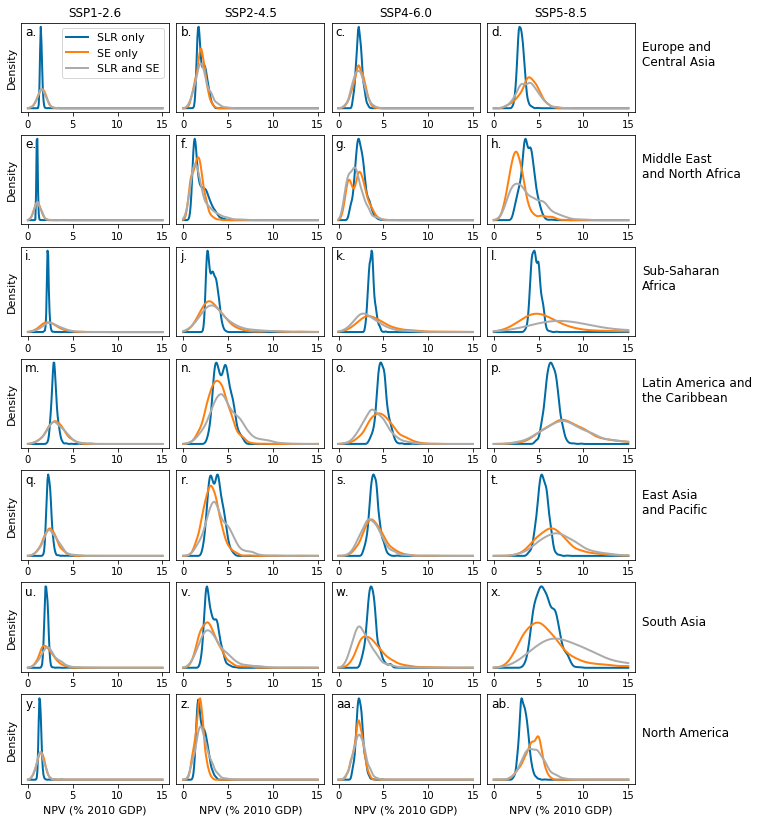

In [160]:
panels = ["a.","b.","c.","d.","e.","f.","g.","h.","i.","j.","k.","l.","m.", \
          "n.","o.","p.","q.","r.","s.","t.","u.","v.","w.","x.","y.","z.", \
          "aa.","ab.","ac.","ad."]
region_labels = ["Europe and\nCentral Asia",
                 "Middle East\nand North Africa",
                 "Sub-Saharan\nAfrica",
                 "Latin America and\nthe Caribbean",
                 "East Asia\nand Pacific",
                 "South Asia",
                 "North America"]
fig, ax = plt.subplots(7,4,figsize=(11,14))
fig.subplots_adjust(hspace=.25,wspace=0.05)
bins = range(0,20,1)

pan = 0
for rgn in regions:
    for scen in scenarios:
        ssp,rcp = scen
        row, col = int(pan/4), pan%4
        ax[row][col].plot(x, kde_plot[scen]["S"][rgn], linewidth=2, color="C0", label="SLR only")
        ax[row][col].plot(x, kde_plot[scen]["C"][rgn], linewidth=2, color="C1", label="SE only")
        ax[row][col].plot(x, kde_plot[scen]["SC"][rgn], linewidth=2, color="C2", label="SLR and SE")
        if row==6:
            ax[row][col].set_xlabel("NPV (% 2010 GDP)", fontsize=11)
        if col==0:
            ax[row][col].set_ylabel("Density", fontsize=11);
        ax[row][col].set_yticks([])
        if row==0:
            if col==0:
                ax[row][col].set_title("SSP1-2.6", fontsize=12)
            elif col==1:
                ax[row][col].set_title("SSP2-4.5", fontsize=12)
            elif col==2:
                ax[row][col].set_title("SSP4-6.0", fontsize=12)
            elif col==3:
                ax[row][col].set_title("SSP5-8.5", fontsize=12)
        ylims = ax[row][col].get_ylim(); top = ylims[1]*0.85; ax[row][col].text(-0.3,top, panels[pan], fontsize=12);
        xlims = ax[row][col].get_xlim(); right = xlims[1]*1.05; mid = ylims[1]*0.5
        if col==3:
            ax[row][col].text(right,mid,region_labels[row],fontsize=12)
        if pan==0:
            ax[row][col].legend(fontsize=11)
        pan += 1

fig.savefig(plotdir+"/regional_damages_ssprcp.pdf", bbox_inches='tight')
    

Original plot, one version for each SSP-RCP:

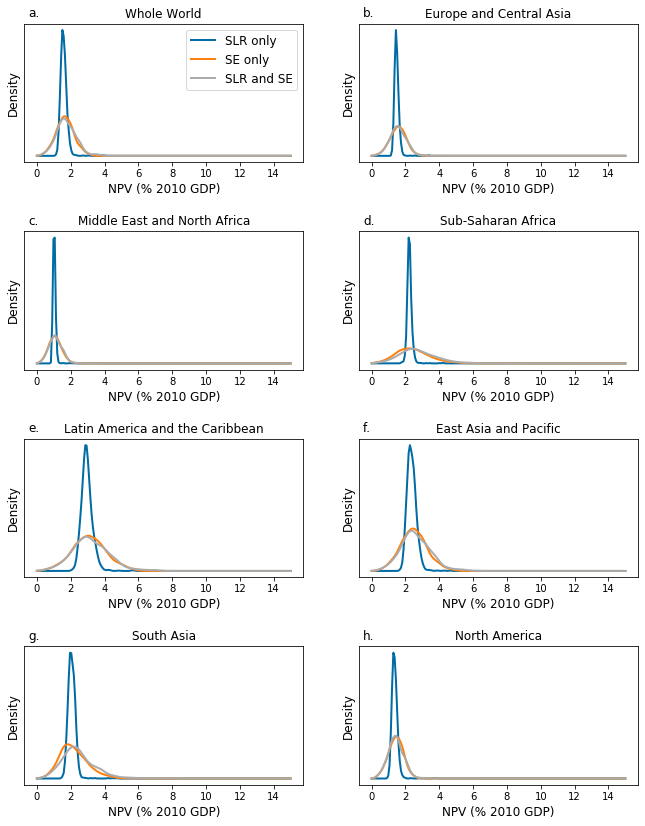

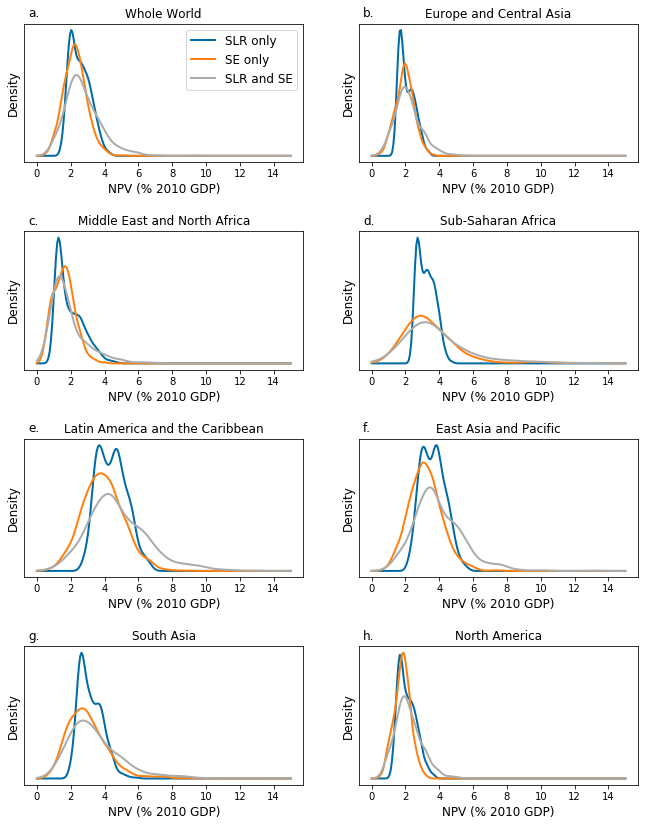

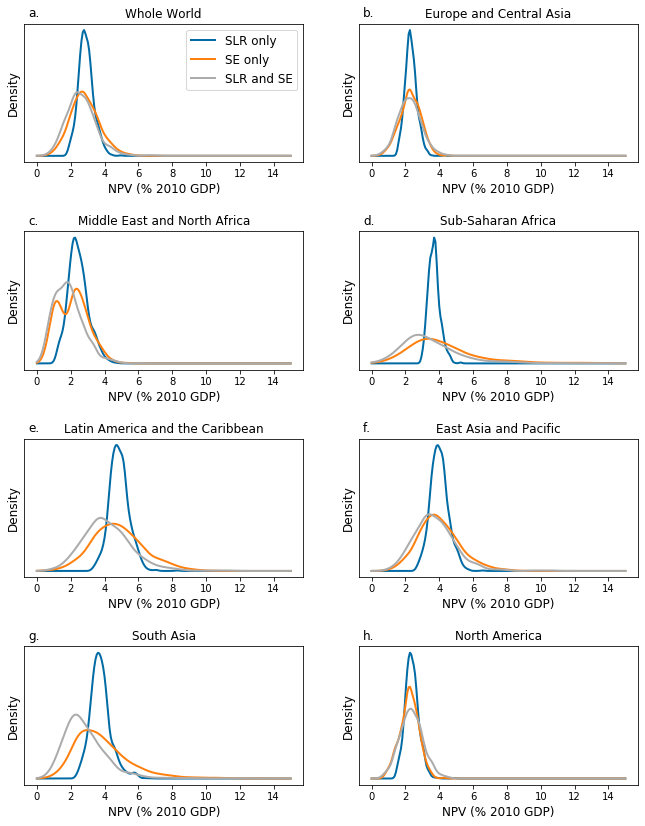

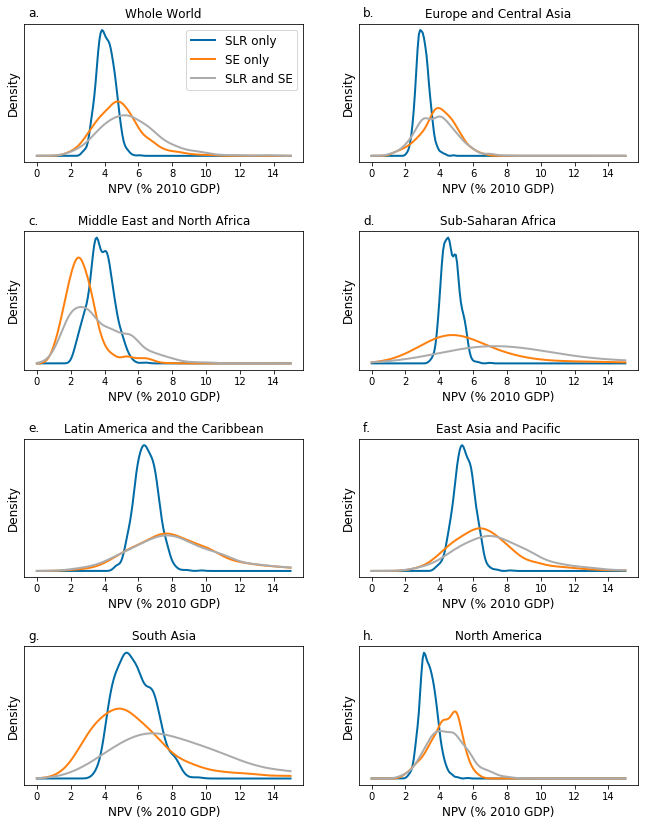

In [161]:
panels = ["a.","b.","c.","d.","e.","f.","g.","h."]

for scen in scenarios:
    ssp,rcp = scen
    
    fig, ax = plt.subplots(4,2,figsize=(11,14))
    fig.subplots_adjust(hspace=.5)
    bins = range(0,20,1)

    # whole world
    rgn = "World"
    pan = 0
    ax[0][0].plot(x, kde_plot[scen]["S"][rgn], linewidth=2, color="C0", label="SLR only")
    ax[0][0].plot(x, kde_plot[scen]["C"][rgn], linewidth=2, color="C1", label="SE only")
    ax[0][0].plot(x, kde_plot[scen]["SC"][rgn], linewidth=2, color="C2", label="SLR and SE")
    ax[0][0].set_xlabel("NPV (% 2010 GDP)", fontsize=12)
    ax[0][0].set_ylabel("Density", fontsize=12); ax[0][0].set_yticks([])
    ax[0][0].legend(fontsize=12, frameon=True)
    ax[0][0].set_title("Whole World")
    #ylims = ax[0][0].get_ylim(); top = ylims[1]+.05*(ylims[1]-ylims[0]); ax[0][0].text(-0.5,top,"a.", fontsize=12)
    ylims = ax[0][0].get_ylim(); top = ylims[1]*1.05; ax[0][0].text(-0.5,top, panels[pan], fontsize=12);

    # regions
    rgn = regions[0]
    pan += 1
    ax[0][1].plot(x, kde_plot[scen]["S"][rgn], linewidth=2, color="C0", label="SLR only")
    ax[0][1].plot(x, kde_plot[scen]["C"][rgn], linewidth=2, color="C1", label="SE only")
    ax[0][1].plot(x, kde_plot[scen]["SC"][rgn], linewidth=2, color="C2", label="SLR and SE")
    ax[0][1].set_xlabel("NPV (% 2010 GDP)", fontsize=12)
    ax[0][1].set_ylabel("Density", fontsize=12); ax[0][1].set_yticks([])
    ax[0][1].set_title(rgn)
    ylims = ax[0][1].get_ylim(); top = ylims[1]*1.05; ax[0][1].text(-0.5,top, panels[pan], fontsize=12);

    ir = 1
    for row in range(1,4):
        for col in range(2):
            rgn = regions[ir]
            ir += 1
            pan += 1
            ax[row][col].plot(x, kde_plot[scen]["S"][rgn], linewidth=2, color="C0", label="SLR only")
            ax[row][col].plot(x, kde_plot[scen]["C"][rgn], linewidth=2, color="C1", label="SE only")
            ax[row][col].plot(x, kde_plot[scen]["SC"][rgn], linewidth=2, color="C2", label="SLR and SE")
            ax[row][col].set_xlabel("NPV (% 2010 GDP)", fontsize=12)
            ax[row][col].set_ylabel("Density", fontsize=12); ax[row][col].set_yticks([])
            ax[row][col].set_title(rgn)
            ylims = ax[row][col].get_ylim(); top = ylims[1]*1.05; ax[row][col].text(-0.5,top, panels[pan], fontsize=12);

    fig.savefig(plotdir+"/regional_damages_ssp"+str(ssp)+"-rcp"+str(rcp)+".pdf", bbox_inches='tight')
    

Regional numbers

In [120]:
print("5th, 50th, 95th, and 95-5th percentiles")
for scen in scenarios:
    print("====================================================")
    print(scen)
    print("====================================================")
    print("World")
    print("  SLR-only ensemble:   ",np.round([dfS[scen]["npv/gpd"].quantile(.05), dfS[scen]["npv/gpd"].quantile(.5), dfS[scen]["npv/gpd"].quantile(.95), dfS[scen]["npv/gpd"].quantile(.95)-dfS[scen]["npv/gpd"].quantile(.05)], 2))
    print("  SE-only ensemble:    ",np.round([dfC[scen]["npv/gpd"].quantile(.05), dfC[scen]["npv/gpd"].quantile(.5), dfC[scen]["npv/gpd"].quantile(.95), dfC[scen]["npv/gpd"].quantile(.95)-dfC[scen]["npv/gpd"].quantile(.05)], 2))
    print("  SLR and SE ensemble: ",np.round([dfSC[scen]["npv/gpd"].quantile(.05), dfSC[scen]["npv/gpd"].quantile(.5), dfSC[scen]["npv/gpd"].quantile(.95), dfSC[scen]["npv/gpd"].quantile(.95)-dfSC[scen]["npv/gpd"].quantile(.05)], 2))
    for rgn in regions:
        print("=========================")
        print(rgn)
        print("  SLR-only ensemble:   ",np.round([dfS[scen]["npv/gpd "+rgn].quantile(.05), dfS[scen]["npv/gpd "+rgn].quantile(.5), dfS[scen]["npv/gpd "+rgn].quantile(.95), dfS[scen]["npv/gpd "+rgn].quantile(.95)-dfS[scen]["npv/gpd "+rgn].quantile(.05)], 2))
        print("  SE-only ensemble:    ",np.round([dfC[scen]["npv/gpd "+rgn].quantile(.05), dfC[scen]["npv/gpd "+rgn].quantile(.5), dfC[scen]["npv/gpd "+rgn].quantile(.95), dfC[scen]["npv/gpd "+rgn].quantile(.95)-dfC[scen]["npv/gpd "+rgn].quantile(.05)], 2))
        print("  SLR and SE ensemble: ",np.round([dfSC[scen]["npv/gpd "+rgn].quantile(.05), dfSC[scen]["npv/gpd "+rgn].quantile(.5), dfSC[scen]["npv/gpd "+rgn].quantile(.95), dfSC[scen]["npv/gpd "+rgn].quantile(.95)-dfSC[scen]["npv/gpd "+rgn].quantile(.05)], 2))


5th, 50th, 95th, and 95-5th percentiles
(1, 26)
World
  SLR-only ensemble:    [1.34 1.56 1.88 0.55]
  SE-only ensemble:     [0.81 1.65 2.58 1.77]
  SLR and SE ensemble:  [0.82 1.69 2.68 1.85]
Europe and Central Asia
  SLR-only ensemble:    [1.3  1.46 1.68 0.38]
  SE-only ensemble:     [0.76 1.56 2.29 1.53]
  SLR and SE ensemble:  [0.78 1.54 2.35 1.57]
Middle East and North Africa
  SLR-only ensemble:    [0.92 1.02 1.15 0.23]
  SE-only ensemble:     [0.46 1.07 1.71 1.25]
  SLR and SE ensemble:  [0.49 1.08 1.75 1.26]
Sub-Saharan Africa
  SLR-only ensemble:    [2.05 2.22 2.45 0.4 ]
  SE-only ensemble:     [0.99 2.35 4.28 3.29]
  SLR and SE ensemble:  [1.14 2.58 4.79 3.65]
Latin America and the Caribbean
  SLR-only ensemble:    [2.49 2.92 3.51 1.02]
  SE-only ensemble:     [1.45 3.08 4.81 3.36]
  SLR and SE ensemble:  [1.49 3.09 4.92 3.44]
East Asia and Pacific
  SLR-only ensemble:    [1.98 2.34 2.82 0.84]
  SE-only ensemble:     [1.23 2.47 3.86 2.63]
  SLR and SE ensemble:  [1.26 2.53 4.0

## Check quantiles as sample size changes

Using SSP2-RCP4.5.

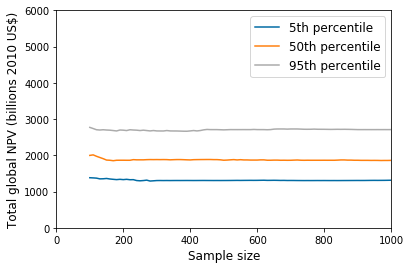

In [121]:
sample_sizes = np.arange(start=100,stop=1100,step=10)
quantiles = np.zeros((len(sample_sizes),3))
for ii in range(len(sample_sizes)):
    quantiles[ii,0] = dfS[(2,45)][:sample_sizes[ii]]["npv"].quantile(.05)
    quantiles[ii,1] = dfS[(2,45)][:sample_sizes[ii]]["npv"].quantile(.5)
    quantiles[ii,2] = dfS[(2,45)][:sample_sizes[ii]]["npv"].quantile(.95)

fig, ax = plt.subplots(1,1,figsize=(6,4))
plt.plot(sample_sizes, quantiles[:,0], label="5th percentile")
plt.plot(sample_sizes, quantiles[:,1], label="50th percentile")
plt.plot(sample_sizes, quantiles[:,2], label="95th percentile")
plt.xlim([0,1000]); plt.ylim([0,6000])
plt.xlabel("Sample size", fontsize=12); plt.ylabel("Total global NPV (billions 2010 US$)", fontsize=12)
plt.legend(loc="best", fontsize=12)
fig.savefig(plotdir+"/quantiles_sample_size.pdf", bbox_inches='tight');

### Write to CSV files for Supplemental Material

First, as percent of regional GDP

In [122]:
percentiles_out = [0,0.01,0.025,0.05,0.17,0.25,0.5,0.75,0.83,0.95,0.975,0.99,1]

for scen in scenarios:
    ssp,rcp = scen
    rgn_dict = {"percentile" : percentiles_out}
    for rgn in regions:
        rgn_dict["SLR-only "+rgn] = dfS[scen]["npv/gpd "+rgn].quantile(percentiles_out)
        rgn_dict["SE-only "+rgn] = dfC[scen]["npv/gpd "+rgn].quantile(percentiles_out)
        rgn_dict["SLR and SE "+rgn] = dfSC[scen]["npv/gpd "+rgn].quantile(percentiles_out)
    dfOut = pd.DataFrame(data=rgn_dict)

    filename_out = datdir+"/FigureData_regional_percentGDP_ensembles_SSP"+str(ssp)+"-RCP"+str(rcp)+".csv"
    dfOut.to_csv(filename_out, index=False)
#print(dfOut)

Now as actual NPV

In [123]:
percentiles_out = [0,0.01,0.025,0.05,0.17,0.25,0.5,0.75,0.83,0.95,0.975,0.99,1]

for scen in scenarios:
    rgn_dict = {"percentile" : percentiles_out}
    for rgn in regions:
        rgn_dict["SLR-only "+rgn] = dfS[scen][rgn].quantile(percentiles_out)
        rgn_dict["SE-only "+rgn] = dfC[scen][rgn].quantile(percentiles_out)
        rgn_dict["SLR and SE "+rgn] = dfSC[scen][rgn].quantile(percentiles_out)
    dfOut = pd.DataFrame(data=rgn_dict)

    filename_out = datdir+"/FigureData_regional_totalNPV_ensembles_SSP"+str(ssp)+"-RCP"+str(rcp)+".csv"
    dfOut.to_csv(filename_out, index=False)
#print(dfOut)